In [68]:
import numpy as np
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

1) Construct a train dataset and represent them.

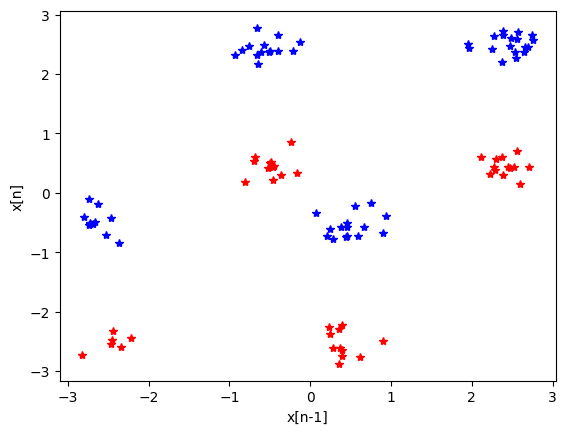

In [69]:
def data(N,a):
   N=N+3
   h=np.array([1,a])
   y=np.sign(np.random.randn(N,1))
   y=np.reshape(y,len(y))
   t=np.arange(N)
   z=np.convolve(h,y)
   z=z[1:N-1]
   y=y[2:N-1]
   X=np.array([z[0:N-3],z[1:N-2]])+0.2*np.random.randn(2,N-3)
   return X,y

N_train = 100  # Number of training samples
a_train = 1.5  # Parameter 'a' for data generation

X_train, y_train = data(N_train, a_train)

ind1=np.where(y_train==1)
ind2=np.where(y_train==-1)
plt.plot(X_train[0,ind1],X_train[1,ind1],'b*')
plt.plot(X_train[0,ind2],X_train[1,ind2],'r*')
plt.xlabel('x[n-1]')
plt.ylabel('x[n]')
plt.show()

2)  Construct a function that computes the kernel matrix K. 

In [70]:
# Sckit-Learn polynomial kernel was used to compute the kernel matrix.

def compute_kernel_matrix(X, degree=3):
    X = X.T
    return polynomial_kernel(X, X, degree=degree)

K_train = compute_kernel_matrix(X_train, degree=3)

3) Compute the dual weights $\alpha_i$ of the MMSE solution. 



In [71]:
def compute_dual_weights(K_train, y_train):
    alpha = np.linalg.inv(K_train + np.eye(len(y_train))).dot(y_train) # alpha = (K + I)^-1 y
    return alpha


alpha = compute_dual_weights(K_train, y_train)

4) Write an estimator in dual form as a function of kernel dot products between the training and test data.

In [72]:
def kernel_estimator(alpha, X_train, X_test, degree=3):
    K_test = polynomial_kernel(X_test.T, X_train.T, degree=degree)
    estimated_y = np.dot(K_test,alpha)
    return estimated_y

5) Plot the boundary

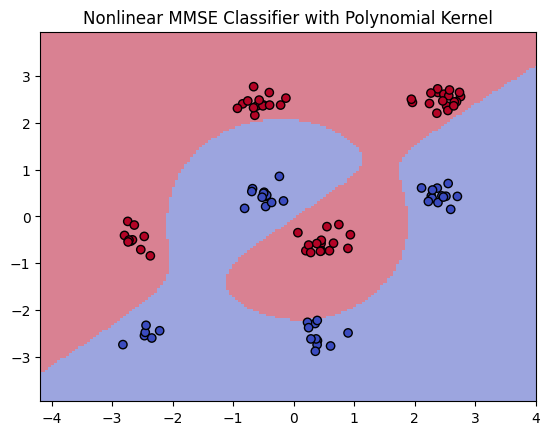

MSE: 0.1645967


In [73]:
N_test = 1000  # Number of test samples
X_test, _ = data(N_test, a_train)

x_min_plot = X_test[0, :].min() - 1
x_max_plot = X_test[0, :].max() + 1
y_min_plot = X_test[1, :].min() - 1
y_max_plot = X_test[1, :].max() + 1

x_meshgrid, y_meshgrid = np.meshgrid(np.arange(x_min_plot, x_max_plot, 0.05), np.arange(y_min_plot, y_max_plot, 0.05))
grid_points = np.c_[x_meshgrid.ravel(), y_meshgrid.ravel()]

# Compute the predicted labels for the grid points
y_pred = kernel_estimator(alpha, X_train, grid_points.T, degree=3)

y_pred = y_pred.reshape(x_meshgrid.shape)

# Plot the decision regions using pcolormesh
plt.pcolormesh(x_meshgrid, y_meshgrid, y_pred > 0, 
               cmap=plt.cm.coolwarm, 
               alpha=0.5, 
               shading='auto'
               )

# Scatter plot for training data points
plt.scatter(X_train[0], X_train[1], c=y_train, 
            cmap=plt.cm.coolwarm, 
            marker='o', 
            edgecolors='k'
            )

plt.xlim(x_meshgrid.min(), x_meshgrid.max())
plt.ylim(y_meshgrid.min(), y_meshgrid.max())
plt.title("Nonlinear MMSE Classifier with Polynomial Kernel")
plt.show()

# Compute the predicted labels for the training set
y_train_pred = kernel_estimator(alpha, X_train, X_train, degree=3)

# Reshape y_train_pred to match the shape of y_train
y_train_pred_flat = y_train_pred.flatten()

mse = np.mean((y_train - y_train_pred_flat)**2)
print(f"MSE: {mse:.7f}")



6) Repeat the experiment, but using the Ridge Regression solution, this is $\alpha=(K+\gamma I)^{-1} y$
    where $\gamma$ is a small number. Show the result for different values of the parameter that are able to produce different solutions.



We are exploring the following gamma values:  [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]
Gamma = 1e-10, MSE = 0.1637
Gamma = 1e-09, MSE = 0.1637
Gamma = 1e-08, MSE = 0.1637
Gamma = 1e-07, MSE = 0.1637
Gamma = 1e-06, MSE = 0.1637
Gamma = 1e-05, MSE = 0.1637
Gamma = 0.0001, MSE = 0.1637
Gamma = 0.001, MSE = 0.1637
Gamma = 0.01, MSE = 0.1637
Gamma = 0.1, MSE = 0.1637
Gamma = 1.0, MSE = 0.1646
Gamma = 10.0, MSE = 0.1962
Gamma = 100.0, MSE = 0.3124
Gamma = 1000.0, MSE = 0.4786
Gamma = 10000.0, MSE = 0.8075
Gamma = 100000.0, MSE = 0.9685
Gamma = 1000000.0, MSE = 0.9966
Gamma = 10000000.0, MSE = 0.9997
Gamma = 100000000.0, MSE = 1.0000
Gamma = 1000000000.0, MSE = 1.0000
Gamma = 10000000000.0, MSE = 1.0000


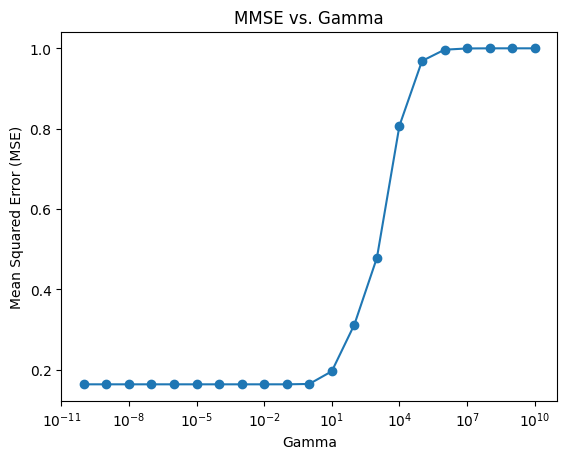

The Minimum MSE is:  0.16368953023749316
The Optimal Gamma is:  1e-09


In [74]:
HighLog = 10
LowLog = -10
NumLog = HighLog - LowLog + 1
gamma_values = np.logspace(LowLog, HighLog, NumLog, base=10)
mse_values = []

print("We are exploring the following gamma values: ", gamma_values)   

for gamma in gamma_values:
    # Step 4: Compute the Ridge Regression weights alpha
    alpha_ridge = np.linalg.inv(K_train + gamma * np.eye(N_train)).dot(y_train) # alpha = (K + gamma*I)^-1 y
    
    # Step 5: Compute the predicted labels for the training data
    y_pred_train = kernel_estimator(alpha_ridge, X_train, X_train, degree=3)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_train - y_pred_train)**2)
    mse_values.append(mse)

    print(f"Gamma = {gamma}, MSE = {mse:.4f}")


# Plot MMSE vs. Gamma
plt.plot(gamma_values, mse_values, marker='o')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MMSE vs. Gamma')
plt.show()

print("The Minimum MSE is: ", min(mse_values))
print("The Optimal Gamma is: ", gamma_values[np.argmin(mse_values)])


We are exploring the following gamma values:  [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05]
Gamma = 1e-10, MSE = 0.1636921


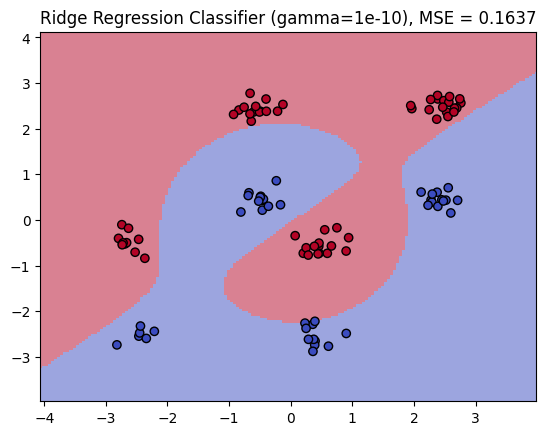

Gamma = 1e-09, MSE = 0.1636895


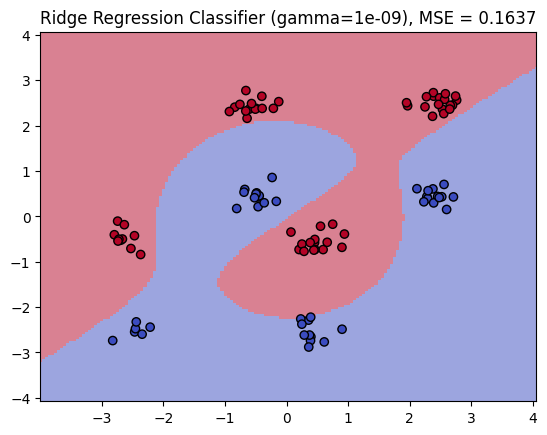

Gamma = 1e-08, MSE = 0.1636899


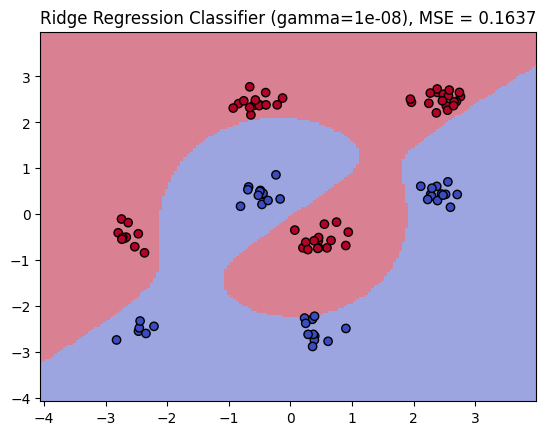

Gamma = 1e-07, MSE = 0.1636897


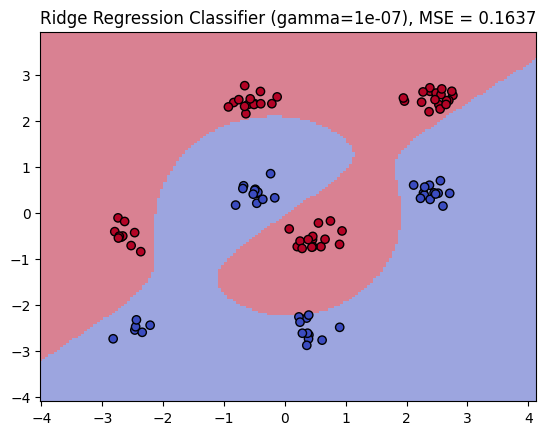

Gamma = 1e-06, MSE = 0.1636897


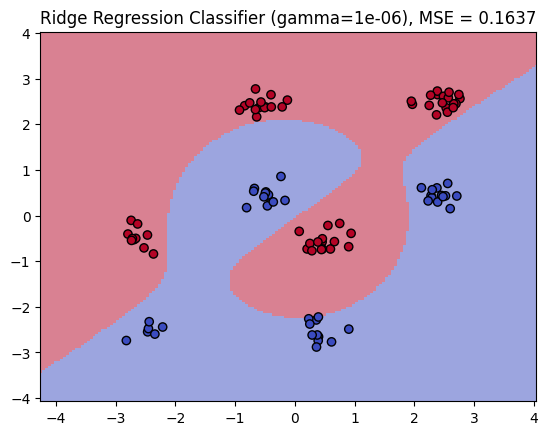

Gamma = 1e-05, MSE = 0.1636897


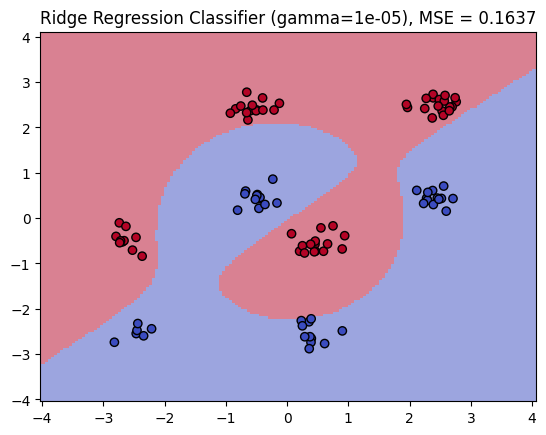

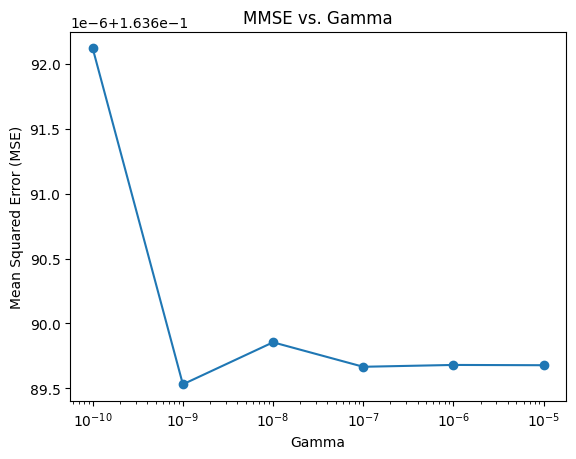

In [75]:
HighLog = -5
LowLog = -10
NumLog = HighLog - LowLog + 1
gamma_values = np.logspace(LowLog, HighLog, NumLog, base=10)
mse_values = []

print("We are exploring the following gamma values: ", gamma_values)   

for gamma in gamma_values:
    # Step 4: Compute the Ridge Regression weights alpha
    alpha_ridge = np.linalg.inv(K_train + gamma * np.eye(N_train)).dot(y_train) # alpha = (K + gamma*I)^-1 y
    
    # Step 5: Compute the predicted labels for the training data
    y_pred_train = kernel_estimator(alpha_ridge, X_train, X_train, degree=3)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_train - y_pred_train)**2)
    mse_values.append(mse)

    print(f"Gamma = {gamma}, MSE = {mse:.7f}")

    # Step 5: Plot the boundary for Ridge Regression
    N_test = 1000  # Number of test samples
    X_test, _ = data(N_test, a_train)

    x_min_plot = X_test[0, :].min() - 1  
    x_max_plot = X_test[0, :].max() + 1
    y_min_plot = X_test[1, :].min() - 1
    y_max_plot = X_test[1, :].max() + 1
    x_meshgrid, y_meshgrid = np.meshgrid(np.arange(x_min_plot, x_max_plot, 0.05), np.arange(y_min_plot, y_max_plot, 0.05))
    grid_points = np.c_[x_meshgrid.ravel(), y_meshgrid.ravel()]

    # Compute the predicted labels for the grid points
    Z_ridge = kernel_estimator(alpha_ridge, X_train, grid_points.T, degree=3)

    Z_ridge = Z_ridge.reshape(x_meshgrid.shape)

    plt.pcolormesh(x_meshgrid, y_meshgrid, Z_ridge > 0, 
                cmap=plt.cm.coolwarm, 
                alpha=0.5, 
                shading='auto'
                )

    # Scatter plot for training data points
    plt.scatter(X_train[0], X_train[1], c=y_train, 
                cmap=plt.cm.coolwarm, 
                marker='o', 
                edgecolors='k'
                )

    plt.xlim(x_meshgrid.min(), x_meshgrid.max())
    plt.ylim(y_meshgrid.min(), y_meshgrid.max())
    plt.title(f"Ridge Regression Classifier (gamma={gamma}), MSE = {mse:.4f}")
    plt.show()


# Plot MMSE vs. Gamma
plt.plot(gamma_values, mse_values, marker='o')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MMSE vs. Gamma')
plt.show()